# Supervised Machine Learning Pipeline


This notebook is a quickstart tutorial on Machine Learning with [sklearn](https://scikit-learn.org/stable/) in Python. It uses a dummy data set of artifical numbers to create some features labelled with x which can be used to predict either a binary target label y of 0s and 1s (classification) or a target variable y of continuous decimal numbers (regression). There is an option to also try XGBoost which requires a separate install as it is not part of sklearn, and also to try the shap package to get more explainability.

In [1]:
# Data manipulation and plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Random feature
import random

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
# from xgboost import XGBClassifier

# Regressors
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor
# from xgboost import XGBRegressor

# Pipeline and evaluation
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, r2_score, median_absolute_error
from sklearn.preprocessing import QuantileTransformer, quantile_transform, RobustScaler
from sklearn.feature_selection import chi2

######### Algorithmic transparency #########
# import lime
# import lime.lime_tabular
# import shap


# Plotting confusion matrices
from sklearn.metrics import confusion_matrix, classification_report
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass
    plt.imshow(cm, interpolation='nearest',
               cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.feature_selection import RFECV

import time

# import regex as re


## Dummy Data

In this section we make up some dummy data by artificially associating the target with some random data for the features. We also introduce some noise so the relationship is not perfect. There is an option for choosing either classification (binary target) or regression (continuous target).

In [2]:
N = 10000 # Number of Samples
N_num = 3 # Numerical Features
C_num = 3 # Categorical Features
S_num = 1 # Square Features
F_num = N_num + C_num + S_num # Total Features

I_num = 5 # Interaction Effects
interaction_multiplier = 20

random_type = 'normal'

def make_random(N, random_type):
    
    if random_type == 'uniform':
        return np.random.rand(N)
    
    if random_type == 'normal':
        return np.random.normal(size=N)

df = pd.DataFrame({ 'x{i}'.format(i=i):  make_random(N, random_type) for i in range(F_num)})

for i in range(C_num):
    
    df['x{i}'.format(i=i)] = (df['x{i}'.format(i=i)] >= 0.5).astype(int)
    
for i in range(C_num, S_num):
    
    df['x{i}'.format(i=i)] = df['x{i}'.format(i=i)] ** 2

reg_or_clf = 'clf' # change this to "clf" to do classification or "reg" to do regression
    
epsilon = 0.1 # Random noise on target
df['y'] = epsilon * (F_num + I_num * interaction_multiplier) * make_random(N, random_type)   
for i in range(F_num):
    
    df['y'] += np.random.rand() * df['x{i}'.format(i=i)]


for i in range(I_num):
    
    i1 = np.random.randint(F_num)
    i2 = np.random.randint(F_num)
    df['y'] += interaction_multiplier * np.random.rand() * df['x{i}'.format(i=i1)] * df['x{i}'.format(i=i2)]
    
# df['y'] = np.arctan(df['y'])
    
if reg_or_clf == 'clf':
    
    df['y'] = (df['y'] >= 0.5).astype(int)
    print('Positive class ratio: {r}'.format(r=df['y'].mean()))
    
df.head(10)

Positive class ratio: 0.6893


,x0,x1,x2,x3,x4,x5,x6,y
0,1,0,1,-0.146241,0.703165,0.610999,0.184113,1
1,0,0,0,1.151587,-0.048115,-0.640281,-2.667028,0
2,0,0,1,0.353285,-0.916362,-0.396046,-0.804053,1
3,0,0,0,0.369483,0.236445,0.492748,0.006584,1
4,1,1,0,0.053537,-0.090560,-1.406447,0.754749,1
5,0,0,0,0.370820,-0.829536,0.208824,-0.943543,1
6,0,0,0,-0.336277,-1.091425,-0.873550,0.107419,0
7,1,0,0,-1.420858,-0.176801,0.598465,-1.170713,0
8,0,0,1,-0.837316,0.835521,-0.130986,-0.644432,1
9,0,0,1,0.177466,-0.004094,0.888295,1.170579,1


## Machine Learning

### Split for Train and Test

In this section the data is split into 70% training and validation, and 30% test. We want to predict y based on X. We will train the algorithm to predict y_train from X_train, then we will test the algorithm later by giving it X_test and seeing how well it predicts y_test.

In [3]:
target = 'y'
features = [col for col in df.columns if col != target]
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train.shape,y_train.shape, X_test.shape, y_test.shape

((7000, 7), (7000,), (3000, 7), (3000,))

### Initiate and run five fold cross validation routine

This section performs algorithm selection and hyperparameter tuning using 5-fold cross-validation. Here you can experiment with different algorithms and their settings to maximise the evaluation metric on the training data. Usually a RandomForest or XGBoost algorithm will win.

In [4]:
rs = 42# random_state for gridsearchcv

# Check the list of available parameters with `pipe.get_params().keys()`

if reg_or_clf == 'clf': # change this to "clf" to do classification or "reg" to do regression
    
    pipe = Pipeline(steps=[
        ('scaler', RobustScaler()), # Important to rescale to compare regression coeffs
        ('clf','passthrough')
    ])

    param_grid = [
#                 {
#             'clf': [
#                 GradientBoostingClassifier(),
#             ],
#             'clf__n_estimators': [30, 150], #150, 200
# #             'clf__criterion':['gini'], #,'gini'
#             'clf__min_samples_split': [2,10,20],
#             'clf__max_depth': [10],
# #             'clf__min_samples_leaf': [12],
# #             'clf__max_features': [20],
# #             'clf__class_weight':['balanced', None],
# #             'clf__max_leaf_nodes' : [20], ########
#             'clf__random_state':[1789]
#         }, 
        {
            'clf': [
                GaussianNB(),
            ],
            'clf__var_smoothing': [1e-9, 1e-7, 1e-5]
        }, 
        {
             'clf': [
               LogisticRegression(solver='lbfgs', #'
                              penalty='l2',
                              fit_intercept=True,
#                               warm_start=True, 
                              #multi_class= 'ovr',
#                               n_jobs=300
                              )
            ],
            'clf__C':[ 0.01, 0.25, 0.50, 1.0],#0.75,0.85,1,2,3,4,5,6
#             'clf__C':[0.001, 0.01, 0.05, 0.25,0.35,0.55,0.75,0.85,1,2,3,4,5,6],#0.75,0.85,1,2,3,4,5,6
            'clf__class_weight':['balanced', None],#None,'balanced',{0:.99, 1:.01},{0:.95, 1:0.05},{0:.9, 1:0.1}
#             'clf__max_iter':[100000, 100]
        }, 
        {
            'clf': [
                RandomForestClassifier()
            ],
            'clf__n_estimators': [100], #150, 200
#             'clf__criterion':['gini'], #,'gini'
            'clf__min_samples_split': [2, 10], #2,10,20 
#             'clf__max_depth': [5,10,15,20],
#             'clf__min_samples_leaf': [12,7,4],
#             'clf__max_features': [10, 20, 30],
#              'clf__class_weight':['balanced', None, {'0':.2, '1':.4, '2':.4}],
#             'clf__class_weight':[ {0:.2, 1:.4, 2:.4}],
#              'clf__max_leaf_nodes' : [10,20,30],
            'clf__random_state':[1789]
        },
#         {
#             'clf': [
#                 XGBClassifier(use_label_encoder=False)
#             ],
#             'clf__n_estimators': [100],
#             'clf__max_depth': [None],
#             'clf__learning_rate': [0.1, 0.2] 
#         },  
#         {
#             'clf': [
#                 ExtraTreesClassifier()
#             ],
#             'clf__n_estimators': [150], #150, 200
# #             'clf__criterion':['gini'], #,'gini'
#             'clf__min_samples_split': [10],
# #             'clf__max_depth': [10],
# #             'clf__min_samples_leaf': [12,7,4],
# #             'clf__max_features': [10, 20, 33],
# #              'clf__class_weight':['balanced', None, {'0':.2, '1':.4, '2':.4}],
# #             'clf__class_weight':[ {0:.2, 1:.4, 2:.4}],
# #             'clf__max_leaf_nodes' : [20], ########
#             'clf__random_state':[1789]
#         },
#         {
#             'clf': [
#                 DecisionTreeClassifier()
#             ],
#             'clf__criterion':['gini'], #,'entropy'
#             'clf__min_samples_split': [2,5,8,10,12],
#             'clf__max_depth': [9], #5,6,7,8,9,10
#             'clf__min_samples_leaf': [8], #,10,12,14,16
#             'clf__max_features': [10,15,20,23, 'sqrt','log2'],
#             'clf__class_weight':['balanced'],
#             'clf__splitter':['random'], #best
#             'clf__max_leaf_nodes' : [5,10,15,20], ######### 5,10,15
#             'clf__min_impurity_split' : [0.36], 
#             'clf__random_state':[1789] # 1998 1 1990 1994 1964 1965 1964
            
#         }, 
    ]
    
    search = GridSearchCV(
        pipe, 
        param_grid,
        cv=StratifiedKFold(5, shuffle = True, random_state=rs), 
        scoring="accuracy", #roc_auc, f1, accuracy, balanced_accuracy, average_precision
        refit = True,
        n_jobs = -1
    )
    
elif reg_or_clf == 'reg':
    
    pipe = Pipeline(steps=[
        ('scaler', RobustScaler()), # Important to rescale to compare regression coeffs
        ('reg','passthrough')
    ])

    param_grid = [
        {
            'reg': [
                LinearRegression(),
            ],
        },
        {
            'reg': [
                Ridge()
            ],
            'reg__alpha':[0.75,0.85,1]
        }, 
#         {
#             'reg': [
#                 TransformedTargetRegressor(
#                     regressor=Ridge(),
#                     transformer=QuantileTransformer(n_quantiles=300, output_distribution='normal')
#                 )
#             ]
#         },
#         {
#             'reg': [
#                 TransformedTargetRegressor(
#                     regressor=LinearRegression(),
#                     transformer=QuantileTransformer(n_quantiles=300, output_distribution='normal')
#                 )
#             ]
#         },
#         {
#             'reg': [
#                 RandomForestRegressor()
#             ],
#             'reg__n_estimators': [100],
# #             'reg__min_samples_split': [12],
# #             'reg__max_depth': [6],
# #             'reg__min_impurity_decrease': [0.7],
#             'reg__min_samples_leaf': [1,10,20,30]
#             #'reg__bootstrap': [True, False]
#         },
#         {
#             'reg': [
#                 XGBRegressor()
#             ],
#             'reg__n_estimators': [150],
#             'reg__max_depth': [None],
#             'reg__learning_rate': [0.1] 
#         },  
    ]

    search = GridSearchCV(
        pipe, 
        param_grid, 
        cv=KFold(5, shuffle = True, random_state=rs), 
        scoring= 'r2',
        refit = True,
        n_jobs = -1
    )
    

In [5]:
# Fit model
t0 = time.time()
search.fit(X_train, y_train.values.reshape(len(y_train),))
t1 = time.time()
print('{tt} minutes to train the algorithm'.format(tt = (t1-t0)/60))

0.04926780064900716 minutes to train the algorithm


## Validation Results

Best parameter (CV score=0.774):
{'clf': RandomForestClassifier(), 'clf__min_samples_split': 10, 'clf__n_estimators': 100, 'clf__random_state': 1789}


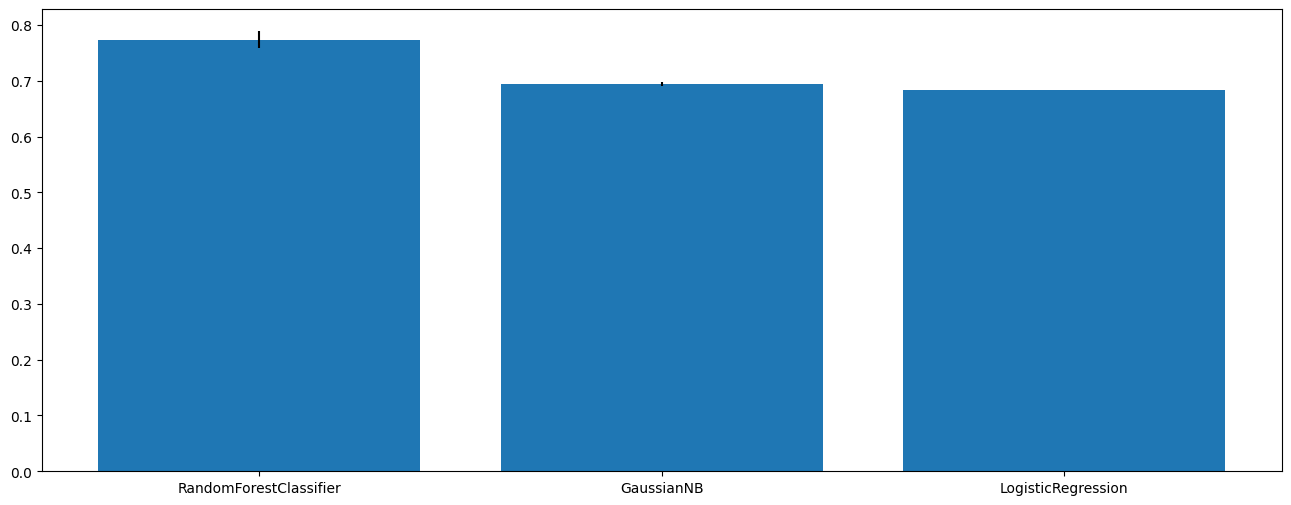

In [6]:
best_algorithm = search.best_estimator_
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Get best version of each algorithm
df_search = pd.DataFrame(search.cv_results_).sort_values('mean_test_score', ascending=False).reset_index(drop=True)

param_type = 'param_{reg_or_clf}_type'.format(reg_or_clf=reg_or_clf)
param = 'param_{reg_or_clf}'.format(reg_or_clf=reg_or_clf)

df_search[param_type] = df_search[param].apply(lambda x: str(type(x)).split('.')[-1][0:-2])

best_inds = []
algo_types = list(set(df_search[param_type]))
for t in algo_types:
    
    best_ind = df_search[df_search[param_type] == t].sort_values('mean_test_score', ascending=False).index[0]
    best_inds.append(best_ind)

df_search_bests = df_search.iloc[best_inds].sort_values('mean_test_score', ascending=False).reset_index(drop=True)

# Make Plot
plt.figure(figsize=(16,6))
plt.bar(
        df_search_bests[param_type], 
        df_search_bests['mean_test_score'],
        yerr=df_search_bests['std_test_score'],
    )
plt.show()

## Feature Importances

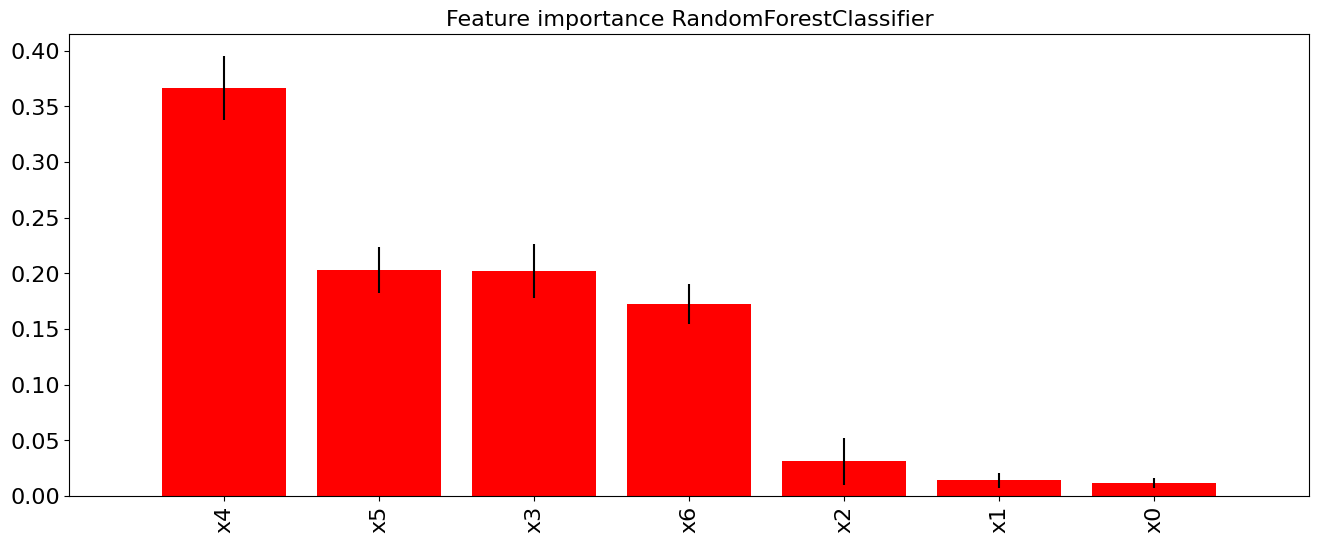

In [7]:
best_algo_type = df_search_bests['param_{algo_type}_type'.format(algo_type=reg_or_clf)].iloc[0]
stps = best_algorithm.steps
alg_ind = [i for i in range(len(stps)) if (stps[i][0]=='reg')|(stps[i][0]=='clf')][0]
model = stps[alg_ind][1]

if (best_algo_type == 'XGBRegressor') | (best_algo_type == 'XGBClassifier'):
    
    importances_dict = model.get_booster().get_score(importance_type="gain")
    feature_names = list(importances_dict.keys())
    importances = [importances_dict[f] for f in feature_names]

    
elif (best_algo_type == 'RandomForestRegressor') | (best_algo_type == 'RandomForestClassifier'):
    
    importances = model.feature_importances_
    yerr = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    feature_names = list(X.columns)
    
    
elif (best_algo_type == 'LinearRegression') | (best_algo_type == 'Ridge'):
    
#     if reg_or_clf == 0:
#         lr_coeffs = list(model.coef_[0])

    importances = list(model.coef_)
    feature_names = list(X.columns)


indices = np.argsort(importances)[::-1]
importances = [importances[i] for i in indices]
feature_names = [feature_names[i] for i in indices]
    
plt.figure(figsize=(16,6))
plt.title("Feature importance {algo_type}".format(algo_type=best_algo_type), fontsize=16)
if (best_algo_type == 'RandomForestRegressor') | (best_algo_type == 'RandomForestClassifier'):
    plt.bar(feature_names, importances, color="r", yerr=yerr[indices], align="center")
else:
    plt.bar(feature_names, importances, color="r", align="center")
plt.xticks(range(len(feature_names)), feature_names, rotation="vertical", fontsize=16)
plt.yticks(fontsize=16)
plt.xlim([-1, len(feature_names)])
plt.show()


In [8]:
# import statistics 
# import math

# lr_model = best_algorithm.steps[0][1]
# chi2score, pvalues = chi2(X_train, y_train)
# dfSTATS = pd.DataFrame({
#     'chi squared score':chi2score,
#     'p-value':['{0:.10f}'.format(p) for p in pvalues]
# },index=features_used)
# dfSTATS['coeff'] = lr_model.coef_[0]
# dfSTATS['odds ratio'] = dfSTATS['coeff'].apply(lambda x: round(np.exp(x), 5))
# dfSTATS = dfSTATS.sort_values(
#     'coeff',
#     #'chi squared score',
#     ascending=False
# )
# dfSTATS = dfSTATS.append(pd.DataFrame({
#     'chi squared score':' - ','p-value':' - ','coeff':lr_model.intercept_[0]},index=['model intercept']))
# dfSTATS.to_csv('logisticRegressionCoeffs.csv')
# print(dfSTATS) 



## Test Results

test accuracy 0.7796666666666666
                    precision    recall  f1-score   support

Negative class (0)       0.66      0.54      0.59       898
Positive class (1)       0.82      0.88      0.85      2102

          accuracy                           0.78      3000
         macro avg       0.74      0.71      0.72      3000
      weighted avg       0.77      0.78      0.77      3000



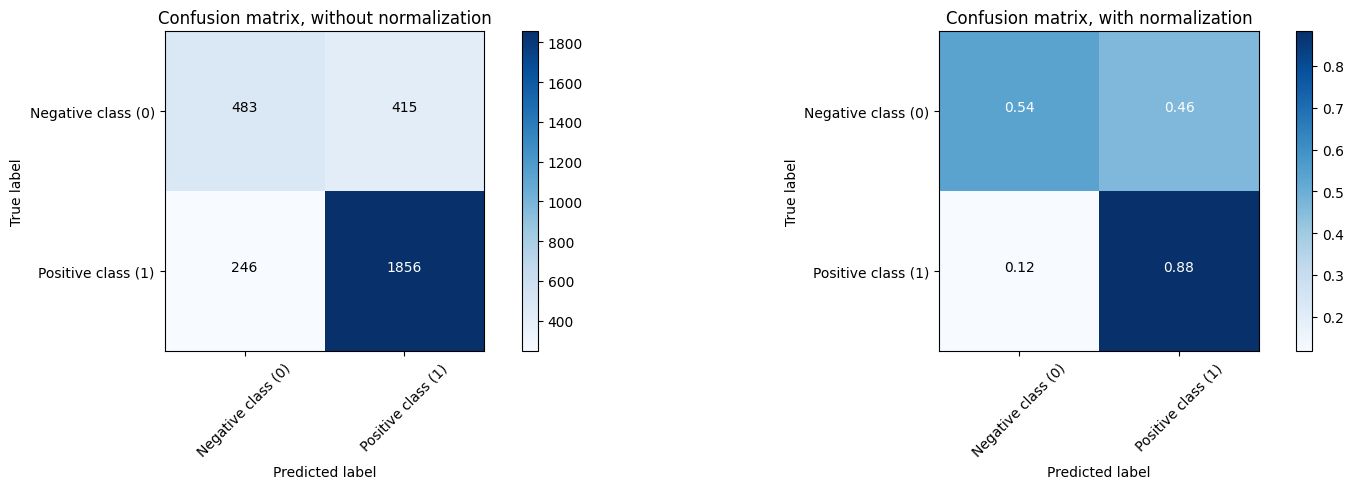

In [9]:
y_pred = best_algorithm.predict(X_test)
y_pred_train = best_algorithm.predict(X_train)

if reg_or_clf == 'clf':
    
    y_prob = best_algorithm.predict_proba(X_test)
    #y_pred = cross_val_predict(best_algorithm, X_train, y_train, cv=StratifiedKFold(5,random_state=rs))
    print('test accuracy', accuracy_score(y_test,y_pred))
    cm = confusion_matrix(y_test, y_pred)
    class_names = ['Negative class (0)','Positive class (1)']
    print(classification_report(y_test, y_pred, target_names=class_names))
    plt.figure(figsize=(16,5))
    plt.subplots_adjust(left=0.4, bottom=None, right=None, top= None, wspace=1.4, hspace=None)
    plt.subplot(1,2,1)
    plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix, without normalization')
    plt.subplot(1,2,2)
    plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Confusion matrix, with normalization')
    plt.show()
    
elif reg_or_clf == 'reg':
    
    print('Median absolute error train', median_absolute_error(y_train, y_pred_train))
    print('R2 train', r2_score(y_train.values, y_pred_train))
    
    print('Median absolute error test', median_absolute_error(y_test, y_pred))
    print('R2 test', r2_score(y_test.values, y_pred))
    
    fig = plt.figure(figsize=(12,12))
    plt.scatter(y_test.values, y_pred, alpha=0.3)
    plt.plot([min(y_test.values), max(y_test.values)], [min(y_test.values), max(y_test.values)], c='r')
    plt.xlabel('y test')
    plt.ylabel('y pred')
    plt.show()

## Feature importance with SHAP

In [10]:
# import shap 
# explainer = shap.TreeExplainer(stps[alg_ind][1])
# shap_values = explainer.shap_values(X_train)

In [ ]:
# shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
# shap.summary_plot(shap_values, X_train)

In [ ]:
# shap.dependence_plot("x6", shap_values, X_train)

In [ ]:
# choosen_instance = X_test.iloc[0]
# shap_values_i = explainer.shap_values(choosen_instance)
# shap.initjs()
# shap.force_plot(explainer.expected_value[1], shap_values_i[1], choosen_instance)

In [ ]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[0], shap_values[1], X_train)